# PyTables 패키지 사용

PyTables 패키지는 파이썬에서 hdf5 데이터 파일 포맷을 사용하기 위한 패키지이다. 

hdf5 파일에 대해서는 다음 노트북을 참조한다.

[[school_notebook:f1c286a1d5164975a9909bb7a341bf4c]]

## 패키지 임포트

PyTables 패키지는 `tables` 라는 이름으로 임포트한다.

In [1]:
import tables as tb
import datetime as dt

테스트를 위해 홈 디렉토리에 data라는 폴더를 만들고 미리 정리한다.

In [2]:
!mkdir -p ~/data
!rm -f ~/data/*.h5
!ls -Fcal ~/data

total 44
drwxr-xr-x  13 dockeruser dockeruser 4096 Jul 21 05:21 ./
drwxr-xr-x 100 dockeruser dockeruser 4096 Jul 21 04:14 ../
drwxr-xr-x  16 dockeruser dockeruser 4096 Jul 10 07:11 BuildingMachineLearningSystemsWithPython/
drwxr-xr-x   2 dockeruser dockeruser 4096 Jul 21 04:55 .ipynb_checkpoints/
drwxr-xr-x   6 dockeruser dockeruser 4096 Jul 10 07:11 neural-networks-and-deep-learning/
drwxr-xr-x   5 dockeruser dockeruser 4096 Jul 10 07:11 nsmc/
drwxr-xr-x   5 dockeruser dockeruser 4096 Jul 10 07:11 py4fi/
drwxr-xr-x  10 dockeruser dockeruser 4096 Jul 10 07:12 pydata-book-master/
drwxr-xr-x   4 dockeruser dockeruser 4096 Jul 10 07:11 scikit-learn-book/
drwxr-xr-x   2 dockeruser dockeruser 4096 Jul 10 07:05 sheather/
drwxr-xr-x   2 dockeruser dockeruser 4096 Jul 10 07:05 tsa/


## hdf5 파일 생성

hdf5 파일을 생성하거나 열때는 `open_file` 명령을 사용한다. 

* http://www.pytables.org/usersguide/libref/top_level.html#tables.open_file

In [3]:
from os.path import expanduser
filename = expanduser("~/data/tab.h5")
h5 = tb.open_file(filename, 'w') 

## 데이터 테이블 생성

데이터 테이블을 생성하기 위해서는 다음과 같이 어떤 자료형의 필드를 사용할지 알려주는 스키마(schema)와 파일 입출력시 사용할 필터(filter)를 정의해야 한다. 

스키마에 사용하는 자료형에 대해서는 다음을 참조한다.

* http://www.pytables.org/usersguide/datatypes.html
* http://www.pytables.org/usersguide/libref/declarative_classes.html#colclassdescr

필터의 주 목적은 압축(compression)이다.

* http://www.pytables.org/usersguide/libref/helper_classes.html#filtersclassdescr

실제 테이블 생성은 파일 객체의 `create_table` 메서드를 사용한다.

In [4]:
row_des = {
    'Date': tb.StringCol(26, pos=1),
    'No1': tb.IntCol(pos=2),
    'No2': tb.IntCol(pos=3),
    'No3': tb.Float64Col(pos=4),
    'No4': tb.Float64Col(pos=5)
    }

In [5]:
filters = tb.Filters(complevel=0)
tab = h5.create_table('/', 'ints_floats', row_des,
                      title='Integers and Floats',
                      filters=filters)

만들어진 테이블은 다음과 같다.

In [6]:
tab

/ints_floats (Table(0,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt='', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1310,)

## 테이블에 데이터 추가

테이블에 실제 데이터를 추가하려면 테이블 객체의 `row` 속성 객체를 사전(dict)처럼 이용하여 필드값을 채운 뒤  `row` 객체가 가진 `append` 메서드로 하나의 행(row)을 추가한다. 모든 데이터 추가가 끝나면 테이블 객체의 `flush` 메서드로 실제 파일을 변경한다.

여기에서는 2,000,000 개의 난수를 생성하여 저장한다.

In [7]:
rows = 2000000

In [8]:
ran_int = np.random.randint(0, 10000, size=(rows, 2))
ran_flo = np.random.standard_normal((rows, 2)).round(5)

In [9]:
pointer = tab.row

In [10]:
%%time
for i in range(rows):
    pointer['Date'] = dt.datetime.now()
    pointer['No1'] = ran_int[i, 0]
    pointer['No2'] = ran_int[i, 1] 
    pointer['No3'] = ran_flo[i, 0]
    pointer['No4'] = ran_flo[i, 1] 
    pointer.append()
tab.flush()

CPU times: user 6.42 s, sys: 3.68 s, total: 10.1 s
Wall time: 10.1 s


In [11]:
tab

/ints_floats (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt='', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1310,)

In [12]:
!ls -Fcal ~/data/tab*

-rw-r--r-- 1 dockeruser dockeruser 100079804 Jul 21 05:21 /home/dockeruser/data/tab.h5


NumPy의 구조화 배열을 사용하면 스키마 정의를 별도로 하지 않아도 된다.

In [13]:
dty = np.dtype([('Date', 'S26'), 
                ('No1', '<i4'), 
                ('No2', '<i4'),
                ('No3', '<f8'), 
                ('No4', '<f8')])
sarray = np.zeros(len(ran_int), dtype=dty)

In [14]:
sarray['Date'] = dt.datetime.now()
sarray['No1'] = ran_int[:, 0]
sarray['No2'] = ran_int[:, 1]
sarray['No3'] = ran_flo[:, 0]
sarray['No4'] = ran_flo[:, 1]

In [15]:
%%time
h5.create_table('/', 'ints_floats_from_array', sarray,
                      title='Integers and Floats',
                      filters=filters)

CPU times: user 30 ms, sys: 30 ms, total: 60 ms
Wall time: 342 ms


/ints_floats_from_array (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt='', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

## 테이블 삭제

테이블을 삭제할 때는 파일 객체의 `remove_node` 메서드를 사용한다.

In [16]:
h5.remove_node('/', 'ints_floats_from_array')

## 데이터 접근

hdf5 테이블의 값은 NumPy 구조화 배열과 같은 방법으로 읽거나 바꿀 수 있다. 테이블 전체의 값을 NumPy 배열로 출력하려면 테이블 객체의 `read` 메서드를 사용한다.

In [17]:
tab[:3]

array([('2016-07-21 05:21:19.368198', 429, 6751, -0.73792, 0.1361),
       ('2016-07-21 05:21:19.368320', 7638, 7941, -0.65428, 1.33854),
       ('2016-07-21 05:21:19.368331', 2239, 5742, -1.08743, 1.76005)], 
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [18]:
tab[:4]['No4']

array([ 0.1361 ,  1.33854,  1.76005, -1.18202])

In [19]:
tab.read()

array([('2016-07-21 05:21:19.368198', 429, 6751, -0.73792, 0.1361),
       ('2016-07-21 05:21:19.368320', 7638, 7941, -0.65428, 1.33854),
       ('2016-07-21 05:21:19.368331', 2239, 5742, -1.08743, 1.76005), ...,
       ('2016-07-21 05:21:29.443509', 164, 5180, -0.13522, -1.14353),
       ('2016-07-21 05:21:29.443514', 8177, 2634, 0.72411, 0.38496),
       ('2016-07-21 05:21:29.443519', 5221, 5929, 0.65805, 0.01043)], 
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

2000000
CPU times: user 190 ms, sys: 150 ms, total: 340 ms
Wall time: 354 ms


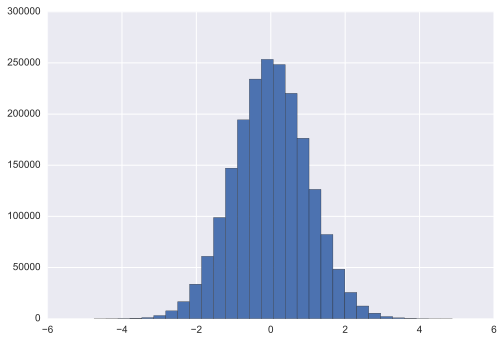

In [20]:
%%time
plt.hist(tab[:]['No3'], bins=30)
plt.grid(True)
print(len(tab[:]['No3']))

In [21]:
%%time
res = np.array([(row['No3'], row['No4']) for row in
        tab.where('((No3 < -0.5) | (No3 > 0.5)) \
                 & ((No4 < -1) | (No4 > 1))')])[::100]

CPU times: user 300 ms, sys: 30 ms, total: 330 ms
Wall time: 335 ms


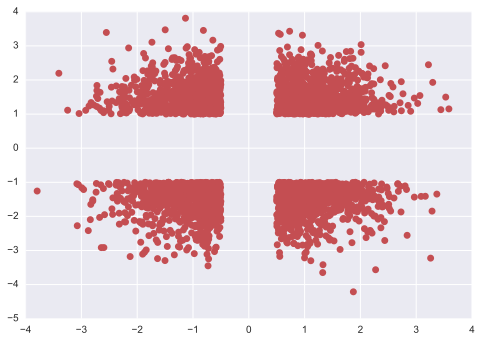

In [22]:
plt.plot(res.T[0], res.T[1], 'ro')
plt.grid(True)

In [23]:
%%time
results = [(row['No1'], row['No2']) for row in
           tab.where('((No1 > 9800) | (No1 < 200)) \
                    & ((No2 > 4500) & (No2 < 5500))')]
for res in results[:4]:
    print(res)

(9987, 4853)
(44, 5218)
(9939, 4822)
(191, 4849)
CPU times: user 70 ms, sys: 0 ns, total: 70 ms
Wall time: 80.4 ms


## 테이블 압축

데이터 파일의 크기를 줄이기 위해 테이블을 압축하려면 필터 생성시 압축 레벨과 압축 알고리즘을 선택한다.

In [24]:
from os.path import expanduser
filename = expanduser("~/data/tabcomp.h5")
h5c = tb.open_file(filename, 'w') 

In [25]:
filters = tb.Filters(complevel=4, complib='blosc')

In [26]:
tabc = h5c.create_table('/', 'ints_floats', sarray,
                        title='Integers and Floats',
                        filters=filters)

In [27]:
%time arr_non = tab.read()

CPU times: user 20 ms, sys: 80 ms, total: 100 ms
Wall time: 102 ms


In [28]:
%time arr_com = tabc.read()

CPU times: user 120 ms, sys: 130 ms, total: 250 ms
Wall time: 437 ms


## 사용 완료

hdf5 파일 사용이 끝나면 `close` 메서드로 파일을 닫아준다.

In [29]:
h5.close()

In [30]:
h5c.close()

In [31]:
!ls -Fcal ~/data/tab*

-rw-r--r-- 1 dockeruser dockeruser  41333836 Jul 21 05:21 /home/dockeruser/data/tabcomp.h5
-rw-r--r-- 1 dockeruser dockeruser 100079804 Jul 21 05:21 /home/dockeruser/data/tab.h5


## 배열 생성

hdf5 에서는 구조화 배열과 같이 복합 자료 구조인 테이블 이외에도 일반 NumPy 배열에 해당하는 array 객체도 지원한다. 

array 객체를 생성할 때는 다음 문서를 참조하여 직접 스키마를 생성하거나 파일 객체의 `create_array` 메서드로 일반 NumPy 배열을 hdf5 파일에 저장할 수도 있다.

* http://www.pytables.org/usersguide/libref/homogenous_storage.html

In [32]:
from os.path import expanduser
filename = expanduser("~/data/array.h5")
h5 = tb.open_file(filename, 'w') 

In [33]:
n = 100
ear = h5.create_earray(h5.root, 'ear',
                       atom=tb.Float64Atom(),
                       shape=(0, n))

In [34]:
%%time
rand = np.random.standard_normal((n, n))
for i in range(750):
    ear.append(rand)
ear.flush()

CPU times: user 50 ms, sys: 30 ms, total: 80 ms
Wall time: 288 ms


In [35]:
ear

/ear (EArray(75000, 100)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (81, 100)

In [36]:
ear.size_on_disk

60004800L

In [37]:
out = h5.create_earray(h5.root, 'out',
                       atom=tb.Float64Atom(),
                       shape=(0, n))

## out-of-core 연산

PyTables 패키지는 numexpr 패키지를 사용하여 out-of-core 연산을 할 수 있다. 
out-of-core 연산이란 메모리에 올릴 수 없는 대량의 데이터를 메모리에 올리지 않고도 파일에서 계산하는 것을 말한다.

In [38]:
expr = tb.Expr('3 * sin(ear) + sqrt(abs(ear))')

In [39]:
expr.set_output(out, append_mode=True)

In [40]:
%time expr.eval()

CPU times: user 140 ms, sys: 50 ms, total: 190 ms
Wall time: 609 ms


/out (EArray(75000, 100)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (81, 100)

In [41]:
out[0, :10]

array([ 4.01835574, -0.94740526,  1.32947972, -0.64233333,  0.65526611,
        2.15179137,  3.45755324, -0.55045709,  1.55076116,  2.74122149])

In [42]:
h5.close()